In [9]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from scipy import signal
from PIL import Image
import math

In [2]:
# API_KEY = os.getenv("ELEVATION_API_KEY")

def get_airmap_data(lat, lng):
    # Gets a grid of elevation data centered around a target point 
    url = "https://api.airmap.com/elevation/v1/ele/carpet?points={},{},{},{}".format(lat+0.01, lng+0.01, lat-0.01, lng-0.01)
    response = requests.get(url)
    response = response.json()
    stats = response['data']['stats']
    carpet = response['data']['carpet']
    return stats, carpet

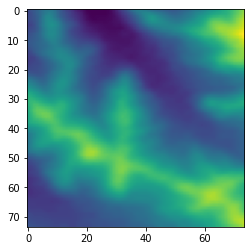

In [3]:
stats, carpet = get_airmap_data(47.6062, 122.3321) # Lat and lng for Seattle
plt.imshow(carpet)
plt.show()

In [36]:
def compute_heatmap(elevation_grid, lat1, lng1, lat2, lng2, n = 5): 
    # Applies a U-shaped kernel (with orientation based on the positions of the soldiers and the party to communicate
    #    with) to the geographical data and returns a list of the best locations (number of locations specified by 
    #    the n parameter)

    
    angle = calculate_bearing_angle(lat1, lng1, lat2, lng2)
    
    sample_filter = np.array([[0, -2, -2, -2, 0],
                              [1, .5, -2, .5, 1],
                              [1, .5, -2, .5, 1],
                              [1,  1, .5,  1, 1],
                              [0,  1,  1,  1, 0]])
    
    rotated_filter = rotate_filter(sample_filter, angle)
    
    corr = signal.correlate2d(elevation_grid, rotated_filter, boundary='symm', mode='valid')          
    best_loc = find_best_locations(corr, n)
    return corr, best_loc


def rotate_filter(filter, degrees):
    # Rotates a 2D array by an angle of degrees, using bilinear interpolation
    
    img = Image.fromarray(filter)
    rotated_img = img.rotate(degrees, resample=Image.BILINEAR)
    rotated_filter = np.asarray(rotated_img)

    return rotated_filter


def calculate_bearing_angle(lat1, lng1, lat2, lng2):
    #Calculates the angle in degrees clockwise from north between the first and second point

    lat1, lng1, lat2, lng2 = math.radians(lat1), math.radians(lng1), math.radians(lat2), math.radians(lng2)
    delta_lng = lng2-lng1

    y = math.cos(lat2) * math.sin(delta_lng)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lng)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    return brng


def find_best_locations(corr, n = 5, radius = 5):
    # Find up to the n-th best locations based on the correlated 2D array (corr)

    max_indices = corr.ravel().argsort()[::-1] # sorted in order from maximum to minimum
    best_loc = [list(np.unravel_index(max_indices[0], corr.shape))]
    occupied_ycoor = [*range(best_loc[0][0]-radius, best_loc[0][0]+(radius+1))]
    occupied_xcoor = [*range(best_loc[0][1]-radius, best_loc[0][1]+(radius+1))]

    for i in max_indices[1:]:
        coordinate = list(np.unravel_index(i, corr.shape))
        if len(best_loc) == n:
            break
        if (coordinate[0] in occupied_ycoor) and (coordinate[1] in occupied_xcoor):
            pass
        else:
            if len(best_loc) < n:
                best_loc.append(coordinate)
                occupied_ycoor += [*range(coordinate[0]-radius, coordinate[0]+(radius+1))]
                occupied_xcoor += [*range(coordinate[1]-radius, coordinate[1]+(radius+1))]

    return best_loc

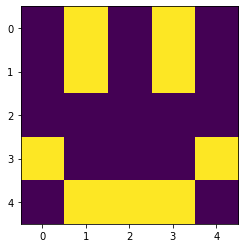

In [32]:
sample_filter = np.array([[0, 1, 0, 1, 0],
                          [0, 1, 0, 1, 0],
                          [0, 0, 0, 0, 0],
                          [1, 0, 0, 0, 1],
                          [0, 1, 1, 1, 0.0]])

plt.imshow(sample_filter)

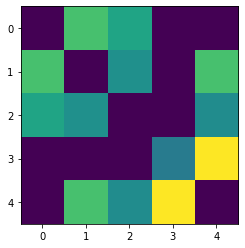

In [33]:
rotated_filter = rotate_filter(sample_filter, 45)
plt.imshow(rotated_filter)

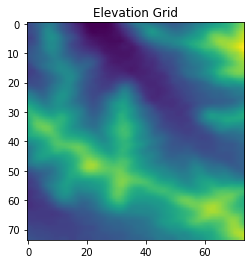

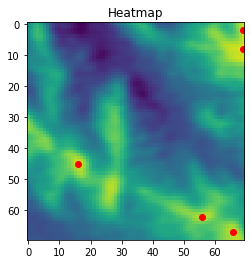

In [37]:
stats, carpet = get_airmap_data(47.6062, 122.3321) # Lat and lng for Seattle
heatmap, best_loc = compute_heatmap(carpet, 39.099912, -94.581213, 38.627089, -90.200203)

plt.figure(1)
plt.title("Elevation Grid")
plt.imshow(carpet)

plt.figure(2)
plt.title("Heatmap")
for i in range(len(best_loc)):
    plt.plot(best_loc[i][1], best_loc[i][0], 'ro')
plt.imshow(heatmap)